# Initialisation and imports

In [1]:
from pprint import pprint  # for pretty-printing python variables like 'dict'
%gui qt
import numpy.random as rd
import matplotlib.pyplot as plt
from functools import partial
import numpy as np

import qcodes as qc
from qcodes import (initialise_database,
                    new_experiment)
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment,
                                                 load_experiment,
                                                 load_by_id,
                                                 load_or_create_experiment
                                                 )
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.plotting import plot_by_id
#QCTools import
import qctools as qct
from qctools.db_extraction import db_extractor
from qctools.doNd import doNd,do1d,do2d,do1d_settle,do2d_settle
from qctools.meta import setparam_meta, getparam_meta, diff_R_G_Ibias, diff_R_G_Vbias, multi_instrument_set, multi_instrument_get

In [2]:
#Initialising new or existing DB:
configuration = qc.config
dbloc = r'.\20200715_Tutorial.db'
configuration['core']['db_location'] = dbloc
configuration.save_to_home()
initialise_database()

## Useful Commands to use with the database, don't run this cell, just read.

In [ ]:
# All you need to load or create an experiment. Consider them chapters in your measurement adventure.
exp = load_or_create_experiment('test', sample_name='no sample')

# Load experiment by experiment id
exp = load_experiment(1)
# Only useful when you forcibly want to create an experiment with an existing name, 
# otherwise load_or_create_experiment will do the trick
exp = new_experiment('test', sample_name='no sample') 

#Visualise your dataset and see IDs
qc.dataset.experiment_container.experiments()
#See the full path of the currently active database
qc.dataset.database.get_DB_location()
#Load measurement run by id
run=load_by_id(8)
#Get parameters of the run (i.e. used set and readout axes)
params = run.get_parameters()
#For other useful stuff, simply use tab completion 
run. #press 'Tab' on this line to see all possible attributes to call
exp. #press 'Tab' on this line to see all possible attributes to call
{instrument_name}.close() #Removes instrument

#Pretty print the snapshot and the description of the run.
pprint(run.description.to_json())
pprint(run.snapshot)
#Get metadata if available
run.get_metadata
#Get name of the run
run.name
#Get number of results
run.number_of_results

## Connect to instruments using drivers

### Dummies

In [3]:
#Dummy DAC
dummydac = DummyInstrument('dac', gates=['ch1', 'ch2'])
#Dummy DMM
dummyimeas = DummyInstrument('imeas', gates=['i1', 'i2'])

### Real instruments using qcodes driver (needs real instrument to run)

In [ ]:
#Connecting to a SR830 lock-in amplifier
from qcodes.instrument_drivers.stanford_research.SR830 import SR830
lockin = SR830(name="lockin",address="GPIB0::10::INSTR") #It lives on virtual GPIB address 10

### Real instruments using qcodes_contrib_drivers (needs real instrument to run)

In [ ]:
from qcodes_contrib_drivers.drivers.unibasel.SP927 import SP927 # import SP927 Unibasel DAC
dac = SP927("DAC","ASRL4::INSTR") # DAC living on virtual COM port 4

## Defining meta instruments

### Dummy meta instruments using 'setparam_meta' and 'getparam_meta'

In [4]:
#Creating backgate meta instrument using dac.ch1
backgate = setparam_meta(name = 'backgate', 
                         label = r'Backgate $V_\mathrm{BG}$', 
                         scale_param = 10, 
                         instrument = dummydac.ch1, 
                         maxVal = 10, 
                         unit = 'V', 
                         inter_delay = 1e-3, 
                         step = 25e-2)
topgate = setparam_meta(name = 'topgate', 
                        label = r'Topgate $V_\mathrm{BG}$', 
                        scale_param = 10, 
                        instrument = dummydac.ch2, 
                        maxVal = 10, 
                        unit = 'V', 
                        inter_delay = 1e-3, 
                        step = 25e-2)

#Creating current measurement meta instrument using dmm.v1
current_measure = getparam_meta(name = 'drain_current',
                                label = r'DC1 $I_\mathrm{SD}$',
                                scale_param = 1e-2,
                                instrument = dummyimeas.i1,
                                unit = 'A')
current_measure2 = getparam_meta(name = 'drain_current2',
                                 label = r'DC2 $I_\mathrm{SD}$',
                                 scale_param = 1e-2,
                                 instrument = dummyimeas.i2,
                                 unit = 'A')

### Dummy model to measure some Gaussian distribution

In [5]:
# and we'll make a 2D gaussian to sample from/measure
from functools import partial
def gauss_model(x0: float, y0: float, sigma: float, noise: float=0.0005):
    """
    Returns a generator sampling a gaussian. The gaussian is
    normalised such that its maximal value is simply 1
    """
    while True:
        (x, y) = yield
        model = np.exp(-((x0-x)**2+(y0-y)**2)/2/sigma**2)*np.exp(2*sigma**2)
        noise = np.random.randn()*noise
        yield model + noise

# and finally wire up the dmm v1 to "measure" the gaussian

gauss = gauss_model(0.1, 0.2, 0.25)
next(gauss)

def measure_gauss(dac):
    val = gauss.send((dac.ch1.get(), dac.ch2.get()))
    next(gauss)
    return val

dummyimeas.i1.get = partial(measure_gauss, dummydac)
dummyimeas.i2.get = partial(measure_gauss, dummydac)

### Example of using lockin metas 'diff_R_G_Ibias' and 'diff_R_G_Vbias' (needs real lockin to run)

In [ ]:
# Meta-instrument for measuring current in a V-biased measurement. 
# Starred arguments must be supplied
lockinVbias_meas = diff_R_G_Vbias(lockin_handle=lockin,  #* lockin handle
                                  V_div=1e3,       #* value of voltage divider on input
                                  IV_gain=1e6,     #* gain of the IV converter
                                  V_ac=40e-3,      #Default: None, raw ac voltage for lockin ('None' uses current one)
                                  trans_gain=1/4,  #Default: 1, transformer gain on lockin input
                                  suffix='1',      #Default: '', adds suffix to distingiush in the case of multiuple lockins
                                  autosense=False, #Default: False, switches autoranging of sensitivity
                                  ntc=3,           #Default: 3, for autosense, number of timeconstants before deciding to switch range
                                  lim=1e-6)        #Default: 1e-6, for autosense, lowest sensitivy limit

# Meta-instrument for measuring a voltage drop in a I-biased measurement. 
# Starred arguments must be supplied 
lockinIbias_meas = diff_R_G_Ibias(lockin_handle=lockin, #* lockin handle 
                                  R_pre=1e6,       #* value of voltage divider on input
                                  V_gain=1e2,      #* gain of the voltage amplifier
                                  V_ac=None,       #Default: None, raw ac voltage for lockin ('None' uses current one)
                                  trans_gain=1/4,  #Default: 1, transformer gain on lockin input
                                  suffix='1',      #Default: '', adds suffix to distingiush in the case of multiuple lockins
                                  autosense=True,  #Default: False, switches autoranging of sensitivity
                                  ntc=3,           #Default: 3, for autosense, number of timeconstants before deciding to switch range
                                  lim=1e-6)        #Default: 1e-6, for autosense, lowest sensitivy limit


# Setting up measurements

## Setup description

![title](img/setup.png)

- Everything connected to everything, except number 2
- Etc.

In [6]:
from qcodes.instrument.parameter import ParameterWithSetpoints, Parameter
from qcodes.instrument.base import Instrument
from qcodes.utils.validators import Numbers, Arrays
from qcodes.dataset.measurements import Measurement
class GeneratedSetPoints(Parameter):
    """
    A parameter that generates a setpoint array from start, stop and num points
    parameters.
    """
    def __init__(self, startparam, stopparam, numpointsparam, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._startparam = startparam
        self._stopparam = stopparam
        self._numpointsparam = numpointsparam

    def get_raw(self):
        return np.linspace(self._startparam(), self._stopparam(),
                              self._numpointsparam())

class DummyArray(ParameterWithSetpoints):

    def get_raw(self):
        npoints = self.root_instrument.n_points.get_latest()
        return np.random.rand(npoints)


class DummySpectrumAnalyzer(Instrument):

    def __init__(self, name, **kwargs):

        super().__init__(name, **kwargs)


        self.add_parameter('f_start',
                           initial_value=0,
                           unit='Hz',
                           label='f start',
                           vals=Numbers(0,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('f_stop',
                           unit='Hz',
                           label='f stop',
                           vals=Numbers(1,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('n_points',
                           unit='',
                           initial_value=10,
                           vals=Numbers(1,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('freq_axis',
                           unit='Hz',
                           label='Freq Axis',
                           parameter_class=GeneratedSetPoints,
                           startparam=self.f_start,
                           stopparam=self.f_stop,
                           numpointsparam=self.n_points,
                           vals=Arrays(shape=(self.n_points.get_latest,)))

        self.add_parameter('spectrum',
                   unit='dBm',
                   setpoints=(self.freq_axis,),
                   label='Spectrum',
                   parameter_class=DummyArray,
                   vals=Arrays(shape=(self.n_points.get_latest,)))

In [7]:
a = DummySpectrumAnalyzer('foobar2')



In [8]:
a.f_start(0)
a.f_stop(500)
a.n_points(11)

In [9]:
a.spectrum.get()

array([0.97211243, 0.81747668, 0.85491456, 0.16407357, 0.18382212,
       0.86512978, 0.81498652, 0.0859867 , 0.62866823, 0.79651829,
       0.8333048 ])

In [10]:
meas = Measurement()
meas.register_parameter(a.spectrum)

with meas.run() as datasaver:
    datasaver.add_result((a.freq_axis, a.freq_axis()),
                         (a.spectrum, a.spectrum()))
    dataset = datasaver.dataset

Starting experimental run with id: 165. 


----------------------  -------------------------------------------------
       Starting runid:  166
                 Name:  IvsV_J1_1V
              Comment:  Looking for some specific feature
       Starting runid:  166
     Set parameter(s):  backgate  5  V
                        topgate   5  V
 Readout parameter(s):  spectrum        {Parameter with setpoints, not shown.}
                        drain_current   0.00153355  A
                        drain_current2  0.00153355  A
______________________  _________________________________________________
    Setpoint: 25 of 25  100.00 % complete.
   Started: 2022-01-06  11:42:10
       ETA: 2022-01-06  11:42:15
  Finished: 2022-01-06  11:42:15
       Total duration:  0:00:05
         Elapsed time:  0:00:05
       Remaining time:  0:00:00


Multi-dimensional data encountered. parameter foobar2_spectrum depends on 3 parameters, cannot plot that.


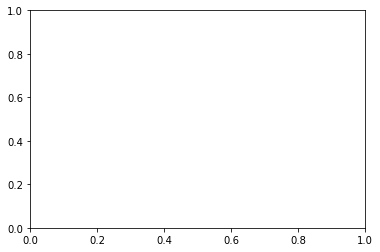

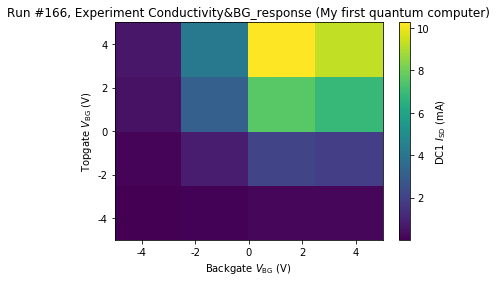

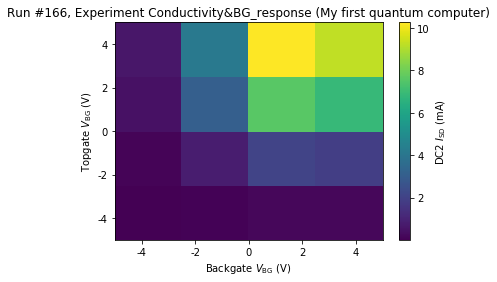

In [11]:
# doNd: Generalised measurement function able to handle an arbitrary number of param_set axes. 
# param_set: List, n-number of set parameters
# spaces: List, n-number of spaces, i.e. setpoints for each param_set in array
# settle_times: List, n-number of settle_times for each param_set in array
# param_meas: List, m-number of measurement parameters in array
# name: String, identifier which cannot have special signs or spaces
# comment: String, descriptive information about measurements, is saved in *.dat file
# meander: Boolean (True/False), sets meandering on first 'slow' axis.
# wait_first_datapoint: Float, waits for x seconds before measuring the first datapoins
# Only parameters denoted with * are required, the others have a default value
import sys
del sys.modules['qctools.doNd'] 
del sys.modules['qctools.db_extraction']
import importlib
importlib.reload(qct)
from qctools.doNd import doNd
from qctools.db_extraction import db_extractor
# Example 2D measurement:
doNd(param_set = [backgate,topgate],                       #*
     spaces= [np.linspace(-5,5,5), np.linspace(-5,5,5)], #*
     settle_times = [1e-2,1e-3],                           #*
     param_meas = [a.spectrum, current_measure, current_measure2],     #*
     name='IvsV_J1_1V',                                    #*
     comment='Looking for some specific feature',
     meander = True, ##Sets meandering on first 'slow' axis.
     wait_first_datapoint=3) ##Waits for n seconds before measuring the first datapoins

In [12]:
a.spectrum.__class__.__bases__

(qcodes.instrument.parameter.ParameterWithSetpoints,)

## IV-s, determining the conductivity and backgate response

In [13]:
#First create an experiment
exp = load_or_create_experiment('Conductivity&BG_response', sample_name='My first quantum computer')

----------------------  -------------------------------------------------
       Starting runid:  164
                 Name:  IvsV_J1_1V
              Comment:  Looking for some specific feature
       Starting runid:  164
     Set parameter(s):  backgate  5  V
                        topgate   5  V
 Readout parameter(s):  drain_current   0.00153355  A
                        drain_current2  0.00153355  A
______________________  _________________________________________________
  Setpoint: 121 of 121  100.00 % complete.
   Started: 2021-08-20  11:31:44
       ETA: 2021-08-20  11:31:56
  Finished: 2021-08-20  11:31:57
       Total duration:  0:00:12
         Elapsed time:  0:00:12
       Remaining time:  0:00:00


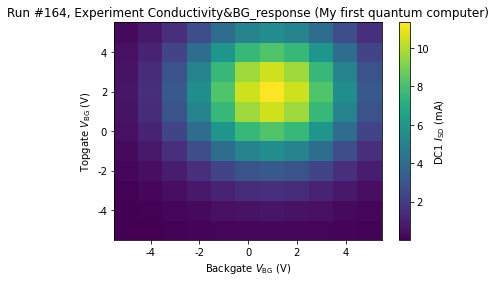

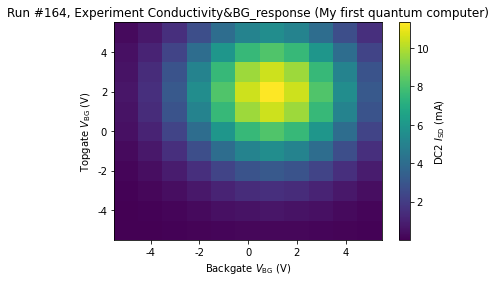

In [12]:
# doNd: Generalised measurement function able to handle an arbitrary number of param_set axes. 
# param_set: List, n-number of set parameters
# spaces: List, n-number of spaces, i.e. setpoints for each param_set in array
# settle_times: List, n-number of settle_times for each param_set in array
# param_meas: List, m-number of measurement parameters in array
# name: String, identifier which cannot have special signs or spaces
# comment: String, descriptive information about measurements, is saved in *.dat file
# meander: Boolean (True/False), sets meandering on first 'slow' axis.
# wait_first_datapoint: Float, waits for x seconds before measuring the first datapoins
# Only parameters denoted with * are required, the others have a default value
import sys
del sys.modules['qctools.doNd'] 
import importlib
importlib.reload(qct)
from qctools.doNd import doNd
# Example 2D measurement:
doNd(param_set = [backgate, topgate],                       #*
     spaces= [np.linspace(-5,5,11), np.linspace(-5,5,11)], #*
     settle_times = [1e-2, 1e-2],                           #*
     param_meas = [current_measure, current_measure2],     #*
     name='IvsV_J1_1V',                                    #*
     comment='Looking for some specific feature',
     meander = True, ##Sets meandering on first 'slow' axis.
     wait_first_datapoint=3) ##Waits for n seconds before measuring the first datapoins

----------------------  -------------------------------------------------
       Starting runid:  159
                 Name:  IvsV_J1_1V
              Comment:  Looking for some specific feature
       Starting runid:  159
     Set parameter(s):  backgate  5  V
 Readout parameter(s):  drain_current   0.00153355  A
                        drain_current2  0.00153355  A
______________________  _________________________________________________
Setpoint: 3001 of 3001  100.00 % complete.
   Started: 2021-08-10  16:40:21
       ETA: 2021-08-10  16:41:13
  Finished: 2021-08-10  16:41:14
       Total duration:  0:00:52
         Elapsed time:  0:00:52
       Remaining time:  0:00:00


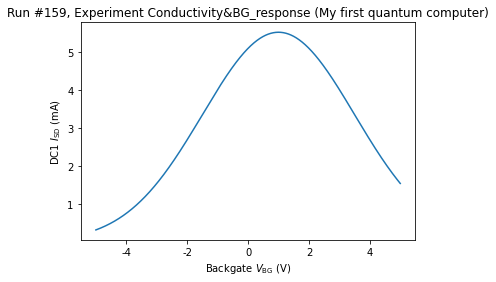

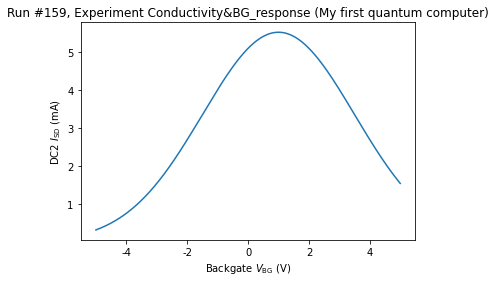

In [15]:
# doNd: Generalised measurement function able to handle an arbitrary number of param_set axes. 
# param_set: List, n-number of set parameters
# spaces: List, n-number of spaces, i.e. setpoints for each param_set in array
# settle_times: List, n-number of settle_times for each param_set in array
# param_meas: List, m-number of measurement parameters in array
# name: String, identifier which cannot have special signs or spaces
# comment: String, descriptive information about measurements, is saved in *.dat file
# meander: Boolean (True/False), sets meandering on first 'slow' axis.
# wait_first_datapoint: Float, waits for x seconds before measuring the first datapoins
# Only parameters denoted with * are required, the others have a default value

# Example 1D measurement:
doNd(param_set = [backgate],              #*
     spaces= [np.linspace(-5,5,3001)],    #*
     settle_times = [1e-3],               #*
     param_meas = [current_measure, current_measure2], #*
     name='IvsV_J1_1V',                   #*
     comment='Looking for some specific feature',
     meander = True, ##Sets meandering on first 'slow' axis.
     wait_first_datapoint=3) ##Waits for n seconds before measuring the first datapoins

## Multi_instrument meta example

In [16]:
# These meta-instruments enable simultaneous sweeping of multiple set_parameters. 
# Their inter-dependence is defined by a slope and an offset with respect to an 
# arbitrary primary 'space' which is given to the doNd function. The function is 
# designed to be quite general and should handle instruments directly as well as 
# previously defined meta-instruments. A separate 'get' metainstrument is required 
# to readout the individiual instruments used in the 'set' instrument.

# Parameters used in both the set and get multi_instrument
instruments = [backgate,topgate]
scale_params = [1,1]
name = 'TopBackgate_sweep'

# Names, units and labels lists are generated for the get meta:
instrumentnames=[None] * len(instruments)
instrumentunits=[None] * len(instruments)
instrumentlabels=[None] * len(instruments)
for i in range(0,len(instruments)):
    instrumentnames[i] = instruments[i].name
    instrumentunits[i] = instruments[i].unit
    instrumentlabels[i] = instruments[i].label

# Set parameter for multi_instrument
coupledgates_set= multi_instrument_set(name = name,
                            label = r'Top+Backgate $V$', 
                            scale_param = scale_params,  # list length n, scale_params for set axes
                            instrument = instruments,    # list length n, instrument handles
                            slope = [ 1,-0.4],           # list length n, slopes with respect to primary
                            offset = [ 0,0.3],           # list length n, offset with respect to primary
                            maxVal = [ 10, 10],          # list length n, maxVal 
                            unit = 'V',                  # string, unit of primary axis
                            inter_delay = [5e-9,5e-9],   # list length n, inter_delays of instruments
                            step = [ 100e-4,100e-4],     # list length n, stepsize of instruments
                            inter_delay_meta = 1e-6,     # float, inter_delay of primary axis
                            step_meta=1e-3)              # float, stepsize of primary axis

# Get parameter for multi_instrument
coupledgates_get = multi_instrument_get(name=name+'_get',
                                 names = instrumentnames, # List of instrument names
                                 labels = instrumentlabels, # List of labels
                                 units = instrumentunits, # List of units
                                 instrument = instruments,  # list of instruments
                                 scale_param = scale_params) # list of scale parameters



----------------------  -------------------------------------------------
       Starting runid:  161
                 Name:  IvsV_J1_1V
              Comment:  Looking for some specific feature
       Starting runid:  161
     Set parameter(s):  TopBackgate_sweep  5  V
 Readout parameter(s):  drain_current          0.00105378  A
                        TopBackgate_sweep_get  backgate  5     V
                                               topgate   -1.7  V
______________________  _________________________________________________
Setpoint: 3001 of 3001  100.00 % complete.
   Started: 2021-08-11  13:33:04
       ETA: 2021-08-11  13:33:57
  Finished: 2021-08-11  13:33:57
       Total duration:  0:00:53
         Elapsed time:  0:00:53
       Remaining time:  0:00:00


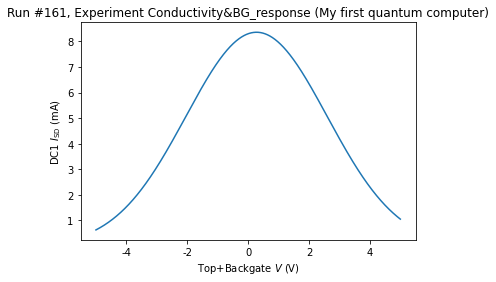

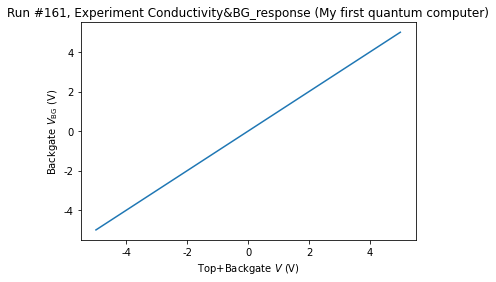

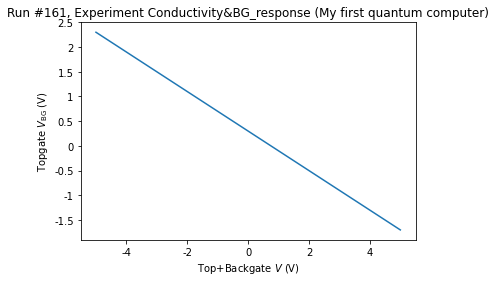

In [18]:
# doNd can now be used as before using 'coupledgates_set' and 'coupledgates_get'
# IMPORTANT: use the argument 'checkstepinterdelay=False' for proper sweeping of individual instruments
import sys
del sys.modules['qctools.doNd'] 
import importlib
importlib.reload(qct)
from qctools.doNd import doNd
doNd(param_set = [coupledgates_set],
     spaces= [np.linspace(-5,5,3001)],
     settle_times = [1e-3],
     param_meas = [current_measure, coupledgates_get], 
     name='IvsV_J1_1V', 
     comment='Looking for some specific feature',
     meander = True,
     wait_first_datapoint=3,
     checkstepinterdelay = False) # <-- IMPORTANT

# Database extraction tool

- You can pass the function the following attributes:

    - dbloc: give it a full database location
    - extractpath: optional, give it a folder to extract to (has to exist). If empty it uses the dbloc path.
    - ids: optional, array of run ids to extract (i.e. ids = np.arange(2,10) extracts runs 2 to 10). If empty it extracts all
    - overwrite: If False, it does not overwrite files when extracting. Default: False
    - timestamp: If True, adds timestamp to foldername per run. Default: True
    - paramtofilename: If True, adds all parameter names to the run filename. Especially handy for people who named their measurements only 'results', makes it more descriptive. Default: False
    - newline_slowaxes: Adds a newline on all slowaxes, works in infinte dimensions, i.e., cube measurements and higher. Default: True
    - no_folders: Creation of folders is supressed. All measurements are put in the same folder with their measurement IDs.
    - suppress_output: Suppresses all print commands


In [86]:
#Extracting the databse with default settings
db_extractor(dbloc=dbloc)

C:\Users\RidderbosJ1\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


*.db file found, continue to unpack...
Saving measurement with id 74 to  D:\git_sync\QCTools\20200715_Tutorial\Exp01(Conductivity&BG_response)-Sample(My_first_quantum_computer)\074_20210809-153953_results\results.dat
Saving measurement with id 75 to  D:\git_sync\QCTools\20200715_Tutorial\Exp01(Conductivity&BG_response)-Sample(My_first_quantum_computer)\075_20210809-154214_IvsV_J1_1V\IvsV_J1_1V.dat
Saving measurement with id 76 to  D:\git_sync\QCTools\20200715_Tutorial\Exp01(Conductivity&BG_response)-Sample(My_first_quantum_computer)\076_20210810-130250_IvsV_J1_1V\IvsV_J1_1V.dat
Saving measurement with id 77 to  D:\git_sync\QCTools\20200715_Tutorial\Exp01(Conductivity&BG_response)-Sample(My_first_quantum_computer)\077_20210810-131950_IvsV_J1_1V\IvsV_J1_1V.dat
Saving measurement with id 78 to  D:\git_sync\QCTools\20200715_Tutorial\Exp01(Conductivity&BG_response)-Sample(My_first_quantum_computer)\078_20210810-132140_IvsV_J1_1V\IvsV_J1_1V.dat
Saving measurement with id 79 to  D:\git_sync\Q

In [13]:
#Example extracting in different path for a single measurement
db_extractor(dbloc=dbloc, 
             extractpath=r'.\20190814_differentpath', 
             ids = [1],
             overwrite = False,
             timestamp = True, 
             paramtofilename = False,
             newline_slowaxes = True,
             no_folders = False,
             suppress_output = False)

*.db file found, continue to unpack...
Saving measurement with id 1 to  Z:\Software_user\qcodes\Interactive_Tutorial\20190814_differentpath\Exp01(Conductivity&BG_response)-Sample(My_first_quantum_computer)\001_20201016-090122_IvsV_J1_1V\IvsV_J1_1V.dat


In [14]:
#Example extracting without a folder structure, and with numbered files
db_extractor(dbloc=dbloc, 
             extractpath=r'.\20200625_nofolders', 
             ids = [],
             overwrite = False,
             timestamp = True, 
             paramtofilename = False,
             newline_slowaxes = True,
             no_folders = True,
             suppress_output = False)

*.db file found, continue to unpack...


In [15]:
#Example extracting without a timestamp, and with numbered files
db_extractor(dbloc=dbloc, 
             extractpath=r'.\20200625_notimestamp', 
             ids = [],
             overwrite = False,
             timestamp = False, 
             paramtofilename = False,
             newline_slowaxes = True,
             no_folders = False,
             suppress_output = False)

*.db file found, continue to unpack...
